<a href="https://www.kaggle.com/code/gkekeskin/real-dopper-rad-dar?scriptVersionId=258829927" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-doppler-raddar-database/Cars/13-54/028.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/024.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/039.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/046.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/051.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/042.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/035.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/036.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/012.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/020.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/009.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/026.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/008.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/055.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/049.csv
/kaggle/input/real-doppler-raddar-database/Cars/13-54/052.csv
/kaggle/

Cars → 5720 Folder. Example: /kaggle/input/real-doppler-raddar-database/Cars/13-13/001.csv
Drones → 5065 Folder. Example: /kaggle/input/real-doppler-raddar-database/Drones/12-34/001.csv
People → 6700 Folder. Example: /kaggle/input/real-doppler-raddar-database/People/10-45f/001.csv
shape: (11, 61) min/max: -164.65 -105.29


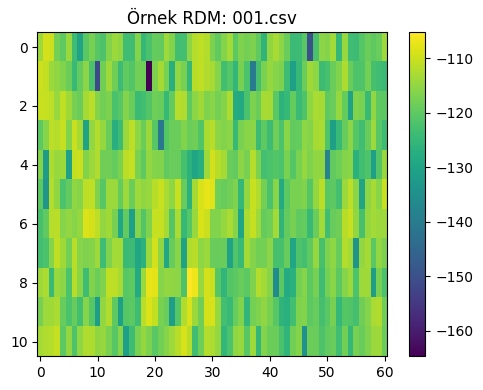

In [3]:
import os, glob, numpy as np, matplotlib.pyplot as plt

ROOT = "/kaggle/input/real-doppler-raddar-database"

for cls in ["Cars","Drones","People"]:
    files = sorted(glob.glob(os.path.join(ROOT, cls, "**", "*.csv"), recursive=True))
    print(cls, "→", len(files), "Folder. Example:", files[0] if files else "-")

# load and display a sample RDM (CSV)
sample_path = sorted(glob.glob(os.path.join(ROOT, "Cars", "**", "*.csv"), recursive=True))[0]
rdm = np.loadtxt(sample_path, delimiter=",", dtype=float)
print("shape:", rdm.shape, "min/max:", rdm.min(), rdm.max())

plt.figure(figsize=(5,4))
plt.imshow(rdm, aspect="auto")
plt.title(f"Örnek RDM: {os.path.basename(sample_path)}")
plt.colorbar(); plt.tight_layout(); plt.show()


In [21]:
import torch, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

class RadarCSVSet(Dataset):
    def __init__(self, root=ROOT, img_size=64, classes=("Cars","Drones","People"), augment=True):
        import numpy as np, glob, os
        self.img_size = img_size
        self.augment = augment
        self.classes = list(classes)
        self.items = []
        for ci, c in enumerate(self.classes):
           paths = sorted(glob.glob(os.path.join(root, c, "**", "*.csv"), recursive=True))
           for p in paths: self.items.append((p, ci))

    def __len__(self): return len(self.items)

    def _load_csv(self, p):
        arr = np.loadtxt(p, delimiter=",", dtype=float)
        # crop 1–99 percent + [0,1] normalize
        lo, hi = np.percentile(arr, 1), np.percentile(arr, 99)
        arr = np.clip(arr, lo, hi)
        arr = (arr - arr.min())/(arr.max() - arr.min() + 1e-6)
       # single channel (1,H,W) and resize
        t = torch.from_numpy(arr).float()[None,None,...]
        t = F.interpolate(t, size=(self.img_size, self.img_size), mode="bilinear", align_corners=False)
        return t[0,0]  # (H,W)

    def _augment(self, x):
        # Small shift + gain + low noise, in line with RDM nature
        if torch.rand(1).item() < 0.5:
            x = torch.roll(x, shifts=int(torch.randint(-3,4,(1,)).item()), dims=0)
            x = torch.roll(x, shifts=int(torch.randint(-3,4,(1,)).item()), dims=1)
        if torch.rand(1).item() < 0.5:
            x = (x * torch.empty(1).uniform_(0.85,1.20)).clamp(0,1)
        if torch.rand(1).item() < 0.3:
            x = (x + torch.randn_like(x)*0.01).clamp(0,1)
        return x

    def __getitem__(self, i):
        p, y = self.items[i]
        x = self._load_csv(p)
        if self.augment: x = self._augment(x)
        return x.unsqueeze(0), torch.tensor(y)


In [22]:
!pip -q install optuna==3.6.1

import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import optuna

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
def seed_all(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
seed_all()


In [23]:
class RadarCNN(nn.Module):
    def __init__(self, num_classes=3, base=32, dropout=0.25):
        super().__init__()
        def block(ci, co, dp):
            return nn.Sequential(
                nn.Conv2d(ci, co, 3, padding=1, bias=False),
                nn.BatchNorm2d(co), nn.ReLU(inplace=True),
                nn.Conv2d(co, co, 3, padding=1, bias=False),
                nn.BatchNorm2d(co), nn.ReLU(inplace=True),
                nn.MaxPool2d(2), nn.Dropout(dp)
            )
        self.features = nn.Sequential(
            block(1, base,   dropout*0.6),
            block(base, base*2, dropout*0.6),
            block(base*2, base*4, dropout*0.6),
            nn.Conv2d(base*4, base*8, 3, padding=1, bias=False),
            nn.BatchNorm2d(base*8), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(base*8, num_classes))

    def forward(self, x):
        return self.fc(self.features(x).flatten(1))

def train_one(model, dl_tr, dl_va, epochs=15, lr=1e-3, wd=0.0, opt_name="adam", patience=4, class_weights=None):
    if opt_name=="sgd":
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=wd)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=2, min_lr=1e-5)

    cw = None
    if class_weights is not None:
        cw = torch.tensor(class_weights, dtype=torch.float32, device=DEVICE)

    best_f1, best_state, wait = 0.0, None, 0
    for ep in range(1, epochs+1):
        model.train(); run=0.0
        for x,y in dl_tr:
            x,y = x.to(DEVICE), y.to(DEVICE)
            loss = F.cross_entropy(model(x), y, weight=cw)
            opt.zero_grad(); loss.backward(); opt.step()
            run += loss.item()*x.size(0)

        model.eval(); preds=[]; gts=[]
        with torch.no_grad():
            for x,y in dl_va:
                p = model(x.to(DEVICE)).argmax(1).cpu().numpy().tolist()
                preds += p; gts += y.numpy().tolist()
        f1 = f1_score(gts, preds, average="macro")
        sched.step(1-f1)

        if f1>best_f1:
            best_f1, best_state, wait = f1, {k:v.detach().cpu() for k,v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait>=patience: break

    if best_state is not None: model.load_state_dict(best_state)
    return best_f1


In [26]:


# To ensure the same order, we extract the indexes with a single "base" dataset
base_for_index = RadarCSVSet(root=ROOT, img_size=64, augment=False)
CLASSES = base_for_index.classes
ITEMS   = base_for_index.items  # (path, label) listesi
labels  = np.array([y for _, y in ITEMS])

# Class weights (against imbalance)
counts = np.bincount(labels, minlength=len(CLASSES))
class_weights = (counts.sum() / (counts + 1e-6)) / len(CLASSES)
print("Class counts:", dict(zip(CLASSES, counts)))
print("Class weights:", np.round(class_weights, 3))

def make_loaders(train_idx, val_idx, img_size=64, batch=64, augment=True):
    # Set up two datasets to keep the same order (same scan, different augment):
    ds_tr_full = RadarCSVSet(root=ROOT, img_size=img_size, augment=augment)
    ds_va_full = RadarCSVSet(root=ROOT, img_size=img_size, augment=False)

    ds_tr = Subset(ds_tr_full, train_idx)
    ds_va = Subset(ds_va_full, val_idx)

    dl_tr = DataLoader(ds_tr, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True)
    dl_va = DataLoader(ds_va, batch_size=batch, shuffle=False, num_workers=2, pin_memory=True)
    return dl_tr, dl_va

Class counts: {'Cars': 5720, 'Drones': 5065, 'People': 6700}
Class weights: [1.019 1.151 0.87 ]


In [27]:
def objective(trial):
    seed_all(SEED)
    img_size = trial.suggest_categorical("img_size", [48, 64, 80])
    base     = trial.suggest_categorical("base", [16, 32, 48])
    dropout  = trial.suggest_float("dropout", 0.20, 0.45)
    batch    = trial.suggest_categorical("batch", [32, 64, 96])
    lr       = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    # LOG-SPACE: low>0 
    wd       = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    opt_name = trial.suggest_categorical("optimizer", ["adam","sgd"])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    f1s = []
    for k,(tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        dl_tr, dl_va = make_loaders(tr_idx, va_idx, img_size=img_size, batch=batch, augment=True)
        model = RadarCNN(num_classes=len(CLASSES), base=base, dropout=dropout).to(DEVICE)
        f1 = train_one(model, dl_tr, dl_va, epochs=15, lr=lr, wd=wd,
                       opt_name=opt_name, patience=4, class_weights=class_weights)
        f1s.append(f1)
        trial.report(float(np.mean(f1s)), step=k)
        if trial.should_prune():
            raise optuna.TrialPruned()
    return float(np.mean(f1s))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=SEED),
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best F1:", study.best_value)
print("Best params:", study.best_params)


[I 2025-08-29 08:41:26,787] A new study created in memory with name: no-name-05452706-d6c5-433d-b678-1195b3b9af9c


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-29 08:52:33,716] Trial 0 finished with value: 0.9365513065080248 and parameters: {'img_size': 64, 'base': 16, 'dropout': 0.21452090304204988, 'batch': 32, 'lr': 0.00010725209743172001, 'weight_decay': 0.0008123245085588687, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9365513065080248.
[I 2025-08-29 08:57:51,657] Trial 1 finished with value: 0.5972778646697176 and parameters: {'img_size': 80, 'base': 16, 'dropout': 0.35296322368059485, 'batch': 96, 'lr': 0.000471705203762518, 'weight_decay': 0.0002267398652378039, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9365513065080248.
[I 2025-08-29 09:09:40,879] Trial 2 finished with value: 0.9133650991781547 and parameters: {'img_size': 80, 'base': 48, 'dropout': 0.44140800826863985, 'batch': 32, 'lr': 0.0010249322216924156, 'weight_decay': 2.091498132903561e-05, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9365513065080248.
[I 2025-08-29 09:18:32,800] Trial 3 finished with value: 0.9133779468186088 and parameters

In [28]:
# ===== 5-FOLD Train=====
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np, torch, torch.nn.functional as F

best = study.best_params
print("BEST HPO params:", best)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

fold_f1s = []
best_fold_f1 = -1
best_fold_idx = -1
fold_paths = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
    print(f"\n==== Fold {fold}/5 ====")
    dl_tr, dl_va = make_loaders(tr_idx, va_idx,
                                img_size=best["img_size"],
                                batch=best["batch"],
                                augment=True)

    model = RadarCNN(num_classes=len(CLASSES),
                     base=best["base"],
                     dropout=best["dropout"]).to(DEVICE)

    f1 = train_one(model, dl_tr, dl_va,
                   epochs=30,
                   lr=best["lr"],
                   wd=best["weight_decay"],
                   opt_name=best["optimizer"],
                   patience=6,
                   class_weights=class_weights)

    # Report
    model.eval(); preds=[]; gts=[]
    with torch.no_grad():
        for x,y in dl_va:
            preds += model(x.to(DEVICE)).argmax(1).cpu().numpy().tolist()
            gts   += y.numpy().tolist()
    rep = classification_report(gts, preds, target_names=CLASSES, output_dict=True)
    macro_f1 = rep["macro avg"]["f1-score"]

    print(f"Fold {fold} macro-F1: {macro_f1:.3f}")
    fold_f1s.append(macro_f1)

    # Save
    path = f"/kaggle/working/radar_cnn_fold{fold}.pt"
    torch.save({"model": model.state_dict(),
                "classes": CLASSES,
                "params": best,
                "fold": fold}, path)
    fold_paths.append(path)

    if macro_f1 > best_fold_f1:
        best_fold_f1 = macro_f1
        best_fold_idx = fold
        # save the best fold with a separate name
        torch.save({"model": model.state_dict(),
                    "classes": CLASSES,
                    "params": best,
                    "fold": fold},
                   "/kaggle/working/radar_cnn_best_single_fold.pt")

print("\n==== 5-fold result ====")
print("Fold F1:", [round(x,3) for x in fold_f1s])
print("Average F1:", round(float(np.mean(fold_f1s)), 3),
      "±", round(float(np.std(fold_f1s)), 3))
print("Best fold:", best_fold_idx, "F1:", round(best_fold_f1,3))
print("Model files:", fold_paths)


BEST HPO params: {'img_size': 48, 'base': 32, 'dropout': 0.2536556630856995, 'batch': 64, 'lr': 0.0007683107460533693, 'weight_decay': 1.033285556962606e-06, 'optimizer': 'adam'}

==== Fold 1/5 ====
Fold 1 macro-F1: 0.945

==== Fold 2/5 ====
Fold 2 macro-F1: 0.950

==== Fold 3/5 ====
Fold 3 macro-F1: 0.949

==== Fold 4/5 ====
Fold 4 macro-F1: 0.957

==== Fold 5/5 ====
Fold 5 macro-F1: 0.952

==== 5-fold result ====
Fold F1: [0.945, 0.95, 0.949, 0.957, 0.952]
Average F1: 0.95 ± 0.004
Best fold: 4 F1: 0.957
Model files: ['/kaggle/working/radar_cnn_fold1.pt', '/kaggle/working/radar_cnn_fold2.pt', '/kaggle/working/radar_cnn_fold3.pt', '/kaggle/working/radar_cnn_fold4.pt', '/kaggle/working/radar_cnn_fold5.pt']


In [29]:
# =====5-FOLD ENSEMBLE EVALUATION =====
import numpy as np, torch, torch.nn.functional as F
from sklearn.metrics import classification_report, f1_score

def ensemble_predict(model_paths, loader, base, dropout):
    probs_all = []
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(DEVICE)
            agg = None
            for p in model_paths:
                m = RadarCNN(num_classes=len(CLASSES), base=base, dropout=dropout).to(DEVICE)
                state = torch.load(p, map_location=DEVICE)["model"]
                m.load_state_dict(state); m.eval()
                out = F.softmax(m(x), dim=1)
                agg = out if agg is None else agg + out
            probs_all.append(agg / len(model_paths))  # average
    return torch.vstack(probs_all)

# 1) Ensemble prediction 
ens_probs = ensemble_predict(fold_paths, dl_va, best["base"], best["dropout"])
ens_preds = ens_probs.argmax(1).cpu().numpy()

# ground-truth 
gts = []
for _,y in dl_va:
    gts += y.numpy().tolist()
gts = np.array(gts)

# 2) Ensemble Report
print("== Ensemble report ==")
print(classification_report(gts, ens_preds, target_names=CLASSES))
print("Ensemble macro-F1:", round(f1_score(gts, ens_preds, average="macro"), 3))

# 3) Comparison: with the best single fold model
best_single_path = "/kaggle/working/radar_cnn_best_single_fold.pt"  # 5-fold training block recorded
best_state = torch.load(best_single_path, map_location=DEVICE)["model"]
best_single = RadarCNN(num_classes=len(CLASSES), base=best["base"], dropout=best["dropout"]).to(DEVICE)
best_single.load_state_dict(best_state); best_single.eval()

single_preds = []
with torch.no_grad():
    for x,_ in dl_va:
        x = x.to(DEVICE)
        p = best_single(x).argmax(1).cpu().numpy().tolist()
        single_preds += p

print("\n== Best single fold report ==")
print(classification_report(gts, single_preds, target_names=CLASSES))
print("Single macro-F1:", round(f1_score(gts, single_preds, average="macro"), 3))

#4) (Optional) Save Ensemble probabilities
np.save("/kaggle/working/ensemble_probs.npy", ens_probs.cpu().numpy())
print("\nSaved ensemble probs → /kaggle/working/ensemble_probs.npy")


== Ensemble report ==
              precision    recall  f1-score   support

        Cars       1.00      0.93      0.96      1144
      Drones       0.93      1.00      0.96      1013
      People       1.00      1.00      1.00      1340

    accuracy                           0.98      3497
   macro avg       0.97      0.98      0.97      3497
weighted avg       0.98      0.98      0.98      3497

Ensemble macro-F1: 0.974

== Best single fold report ==
              precision    recall  f1-score   support

        Cars       0.99      0.91      0.95      1144
      Drones       0.90      0.99      0.94      1013
      People       1.00      0.99      1.00      1340

    accuracy                           0.97      3497
   macro avg       0.96      0.96      0.96      3497
weighted avg       0.97      0.97      0.97      3497

Single macro-F1: 0.963

Saved ensemble probs → /kaggle/working/ensemble_probs.npy
